**You may need to install [OpenCV](https://pypi.python.org/pypi/opencv-python) and [scikit-video](http://www.scikit-video.org/stable/).**

In [1]:
import keras
import numpy as np
import io
import base64
from IPython.display import HTML
#import skvideo.io
import cv2
import json
import pickle
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from keras.models import Sequential,model_from_json
from keras.layers.core import Dense
from keras.optimizers import sgd, Adam
from keras.layers import Flatten, Conv2D, MaxPooling2D, Activation, AveragePooling2D,Reshape,BatchNormalization

Using TensorFlow backend.


# MiniProject on Deep Reinforcement Learning

__Notations__: $E_p$ is the expectation under probability $p$. Please justify each of your answer and widely comment your code.

# Context

In a reinforcement learning algorithm, we modelize each step $t$ as an action $a_t$ obtained from a state $s_t$, i.e. $\{(a_{t},s_{t})_{t\leq T}\}$ having the Markov property. We consider a discount factor $\gamma \in [0,1]$ that ensures convergence. The goal is to find among all the policies $\pi$, one that maximizes the expected reward:

\begin{equation*}
R(\pi)=\sum_{t\leq T}E_{p^{\pi}}[\gamma^t r(s_{t},a_{t})] \> ,
\end{equation*}

where: 
\begin{equation*}p^{\pi}(a_{0},a_{1},s_{1},...,a_{T},s_{T})=p(a_{0})\prod_{t=1}^{T}\pi(a_{t}|s_{t})p(s_{t+1}|s_{t},a_{t}) \> .
\end{equation*}

We note the $Q$-function:

\begin{equation*}Q^\pi(s,a)=E_{p^{\pi}}[\sum_{t\leq T}\gamma^{t}r(s_{t},a_{t})|s_{0}=s,a_{0}=a] \> .
\end{equation*}

Thus, the optimal Q function is:
\begin{equation*}
Q^*(s,a)=\max_{\pi}Q^\pi(s,a) \> .
\end{equation*}

In this project, we will apply the deep reinforcement learning techniques to a simple game: an agent will have to learn from scratch a policy that will permit it maximizing a reward.

## The environment, the agent and the game

### The environment

```Environment``` is an abstract class that represents the states, rewards, and actions to obtain the new state.

In [0]:
class Environment(object):
    def __init__(self):
        pass

    def act(self, act):
        """
        One can act on the environment and obtain its reaction:
        - the new state
        - the reward of the new state
        - should we continue the game?

        :return: state, reward, game_over
        """
        pass


    def reset(self):
        """
        Reinitialize the environment to a random state and returns
        the original state

        :return: state
        """
        pass
    
    def draw(self):
        """
        Visualize in the console or graphically the current state
        """
        pass

The method ```act``` allows to act on the environment at a given state $s_t$ (stored internally), via action $a_t$. The method will return the new state $s_{t+1}$, the reward $r(s_{t},a_{t})$ and determines if $t\leq T$ (*game_over*).

The method ```reset``` simply reinitializes the environment to a random state $s_0$.

The method ```draw``` displays the current state $s_t$ (this is useful to check the behavior of the Agent).

We modelize $s_t$ as a tensor, while $a_t$ is an integer.

### The Agent

The goal of the ```Agent``` is to interact with the ```Environment``` by proposing actions $a_t$ obtained from a given state $s_t$ to attempt to maximize its __reward__ $r(s_t,a_t)$. We propose the following abstract class:

In [0]:
class Agent(object):
    def __init__(self, epsilon=0.1, n_action=4):
        self.epsilon = epsilon
        self.n_action = n_action
    
    def set_epsilon(self,e):
        self.epsilon = e

    def act(self,s,train=True):
        """ This function should return the next action to do:
        an integer between 0 and 4 (not included) with a random exploration of epsilon"""
        if train:
            if np.random.rand() <= self.epsilon:
                a = np.random.randint(0, self.n_action, size=1)[0]
            else:
                a = self.learned_act(s)
        else: # in some cases, this can improve the performance.. remove it if poor performances
            a = self.learned_act(s)

        return a

    def learned_act(self,s):
        """ Act via the policy of the agent, from a given state s
        it proposes an action a"""
        pass

    def reinforce(self, s, n_s, a, r, game_over_):
        """ This function is the core of the learning algorithm. 
        It takes as an input the current state s_, the next state n_s_
        the action a_ used to move from s_ to n_s_ and the reward r_.
        
        Its goal is to learn a policy.
        """
        pass

    def save(self):
        """ This function returns basic stats if applicable: the
        loss and/or the model"""
        pass

    def load(self):
        """ This function allows to restore a model"""
        pass

***
__Question 1__:
Explain the function act. Why is ```epsilon``` essential?

The function act will take the state s in en try and return an action a. During the training with proba $1-epsilon$, the action selected will be the one that the Agent learnt during the training. But, with proba $epsilon$ the agent will select an action randomly. 
This allows the agent to make some trials in order too explore other possibilities than those it already learnt. This is the exploration-exploitation dilema. We want to exploit our best move but in the same time we would like to explore the environment in order to find best strategy.

***
### The Game

The ```Agent``` and the ```Environment``` work in an interlaced way as in the following (take some time to understand this code as it is the core of the project)

```python

epoch = 300
env = Environment()
agent = Agent()


# Number of won games
score = 0
loss = 0


for e in range(epoch):
    # At each epoch, we restart to a fresh game and get the initial state
    state = env.reset()
    # This assumes that the games will end
    game_over = False

    win = 0
    lose = 0
    
    while not game_over:
        # The agent performs an action
        action = agent.act(state)

        # Apply an action to the environment, get the next state, the reward
        # and if the games end
        prev_state = state
        state, reward, game_over = env.act(action)

        # Update the counters
        if reward > 0:
            win = win + reward
        if reward < 0:
            lose = lose -reward

        # Apply the reinforcement strategy
        loss = agent.reinforce(prev_state, state,  action, reward, game_over)

    # Save as a mp4
    if e % 10 == 0:
        env.draw(e)

    # Update stats
    score += win-lose

    print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {}/{} ({})"
          .format(e, epoch, loss, win, lose, win-lose))
    agent.save()
```

# The game, *eat cheese*

A rat runs on an island and tries to eat as much as possible. The island is subdivided into $N\times N$ cells, in which there are cheese (+0.5) and poisonous cells (-1). The rat has a visibility of 2 cells (thus it can see $5^2$ cells). The rat is given a time $T$ to accumulate as much food as possible. It can perform 4 actions: going up, down, left, right. 

The goal is to code an agent to solve this task that will learn by trial and error. We propose the following environment:

In [0]:
class Environment(object):
    def __init__(self, grid_size=10, max_time=500, temperature=0.1):
        grid_size = grid_size+4
        self.grid_size = grid_size
        self.max_time = max_time
        self.temperature = temperature

        #board on which one plays
        self.board = np.zeros((grid_size,grid_size))
        self.position = np.zeros((grid_size,grid_size))

        # coordinate of the cat
        self.x = 0
        self.y = 1

        # self time
        self.t = 0

        self.scale=16

        self.to_draw = np.zeros((max_time+2, grid_size*self.scale, grid_size*self.scale, 3))

    def draw(self,e):
        pickle.dump(self.to_draw/256, open(str(e) + '.pk', 'wb'))

    def get_frame(self,t):
        b = np.zeros((self.grid_size,self.grid_size,3))+128
        b[self.board>0,0] = 256
        b[self.board < 0, 2] = 256
        b[self.x,self.y,:]=256
        b[-2:,:,:]=0
        b[:,-2:,:]=0
        b[:2,:,:]=0
        b[:,:2,:]=0
        
        b =  cv2.resize(b, None, fx=self.scale, fy=self.scale, interpolation=cv2.INTER_NEAREST)

        self.to_draw[t,:,:,:]=b


    def act(self, action):
        """This function returns the new state, reward and decides if the
        game ends."""

        self.get_frame(int(self.t))

        self.position = np.zeros((self.grid_size, self.grid_size))

        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:, :] = -1
        self.position[:,-2:] = -1

        self.position[self.x, self.y] = 1
        if action == 0:
            if self.x == self.grid_size-3:
                self.x = self.x-1
            else:
                self.x = self.x + 1
        elif action == 1:
            if self.x == 2:
                self.x = self.x+1
            else:
                self.x = self.x-1
        elif action == 2:
            if self.y == self.grid_size - 3:
                self.y = self.y - 1
            else:
                self.y = self.y + 1
        elif action == 3:
            if self.y == 2:
                self.y = self.y + 1
            else:
                self.y = self.y - 1
        else:
            RuntimeError('Error: action not recognized')

        self.t = self.t + 1
        reward = self.board[self.x, self.y]
        self.board[self.x, self.y] = 0
        game_over = self.t > self.max_time
        state = np.concatenate((self.board.reshape(self.grid_size, self.grid_size,1),
                        self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)
        state = state[self.x-2:self.x+3,self.y-2:self.y+3,:]

        return state, reward, game_over

    def reset(self):
        """This function resets the game and returns the initial state"""

        self.x = np.random.randint(3, self.grid_size-3, size=1)[0]
        self.y = np.random.randint(3, self.grid_size-3, size=1)[0]


        bonus = 0.5*np.random.binomial(1,self.temperature,size=self.grid_size**2)
        bonus = bonus.reshape(self.grid_size,self.grid_size)

        malus = -1.0*np.random.binomial(1,self.temperature,size=self.grid_size**2)
        malus = malus.reshape(self.grid_size, self.grid_size)

        self.to_draw = np.zeros((self.max_time+2, self.grid_size*self.scale, self.grid_size*self.scale, 3))


        malus[bonus>0]=0

        self.board = bonus + malus

        self.position = np.zeros((self.grid_size, self.grid_size))
        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:, :] = -1
        self.position[:,-2:] = -1
        #self.position[-2:, :] = -1 --> There was a mistake in the position filling
        self.board[self.x,self.y] = 0
        self.t = 0

        state = np.concatenate((
                               self.board.reshape(self.grid_size, self.grid_size,1),
                        self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)

        state = state[self.x - 2:self.x + 3, self.y - 2:self.y + 3, :]
        return state

The following elements are important because they correspond to the hyper parameters for this project:

In [0]:
# parameters
size = 13
T=200
temperature=0.3
epochs_train= 310# set small when debugging
epochs_test= 10# set small when debugging

def display_videos(name):
    video = pickle.load(open(name, 'rb'))
    fig = plt.figure()
    im = plt.imshow(video[0,:,:,:])
    plt.xticks([], [])
    plt.yticks([], [])
    plt.close() # this is required to not display the generated image
    def init():
        im.set_data(video[0,:,:,:])
    def animate(i):
        im.set_data(video[i,:,:,:])
        return im
    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video.shape[0],
                                   interval=50)
    
    return anim.to_html5_video()


__Question 2__ Explain the use of the arrays ```position``` and ```board```.

Position is the array of size (n+2)x(n+2) (with nxn the board dimension) which contains one $zero$ value for each cell of the bord and 4 lines (2 on the left, 2 on the right) and 4 columns (2 on the top 2 on the bottom) of value $-1$ which represents the board limits (2 are necessary to in order to be able to compute the 5x5 states). 
The board will save all the values of the cells, ie the malus values and the bonus values. When the mouse will go move on a cell, the corresponding board value will be zero.

The position array and the board array are used in order to computer the 5x5 state which represent what the mouse can see in its position.



## Random Agent

***
__Question 3__ Implement a random Agent (only ```learned_act``` needs to be implemented):

In [0]:
class RandomAgent(Agent):
    def __init__(self):
        super(RandomAgent, self).__init__()
        self.n_state=2
        pass

    def learned_act(self, s):
        return(np.random.randint(4))
    #I choose a random state among the 4 possibles.

***
***__Question 4__ Visualize the game moves. You need to fill in the following function for the evaluation:

Explanation : In the code below I transform the obtain state of shape 5x5xn_{states} in a array of dimension 1x5x5xn_{states} in order to be able to feed the deep network in learned_act later.
A state is the reunion of the position on the board and the malus bonus for a square of 5x5 cells centered in the mouse position. If we add wether or not the cases have already been visited then we have n_states = 3.

In [0]:
def test(agent,env,epochs,prefix=''):
    # Number of won games
    score = 0
        
    for e in range(epochs):
        
        state = np.zeros((1,5,5,agent.n_state))
        state[0,:,:,:]= env.reset()

        # This assumes that the games will end
        game_over = False

        win = 0
        lose = 0

        while not game_over:
            # The agent performs an action
            action = agent.act(state,train=True)
            
            
            prev_state = state
            state = np.zeros((1,5,5,agent.n_state))
            state[0,:,:,:], reward, game_over = env.act(action) 
            
            # Update the counters
            if reward > 0:
                win = win + reward
            if reward < 0:
                lose = lose -reward

        
        # Save as a mp4
        env.draw(prefix+str(e))

        # Update stats
        score = score + win-lose

        print("Win/lose count {}/{}. Average score ({})"
              .format(win, lose, score/(1+e)))
    print('Final score: '+str(score/epochs))

In [15]:
# Initialize the game
env = Environment(grid_size=size, max_time=T,temperature=0.5)

# Initialize the agent!
agent = RandomAgent()

test(agent,env,epochs_test,prefix='random')
HTML(display_videos('random0.pk'))
#randoms move

Win/lose count 16.5/14.0. Average score (2.5)
Win/lose count 17.0/9.0. Average score (5.25)
Win/lose count 15.5/16.0. Average score (3.3333333333333335)
Win/lose count 19.0/22.0. Average score (1.75)
Win/lose count 18.0/22.0. Average score (0.6)
Win/lose count 21.0/17.0. Average score (1.1666666666666667)
Win/lose count 18.0/20.0. Average score (0.7142857142857143)
Win/lose count 18.0/16.0. Average score (0.875)
Win/lose count 19.5/7.0. Average score (2.1666666666666665)
Win/lose count 9.0/8.0. Average score (2.05)
Final score: 2.05


***
## DQN

Let us assume here that $T=\infty$.

***
__Question 5__ Let $\pi$ be a policy, show that:

\begin{equation*}
Q^{\pi}(s,a)=E_{(s',a')\sim p(.|s,a)}[r(s,a)+\gamma Q^{\pi}(s',a')]
\end{equation*}

Then, show that for the optimal policy $\pi^*$ (we assume its existence), the following holds: 

\begin{equation*}
Q^{*}(s,a)=E_{s'\sim \pi^*(.|s,a)}[r(s,a)+\gamma\max_{a'}Q^{*}(s',a')].
\end{equation*}
Finally, deduce that a plausible objective is:

\begin{equation*}
\mathcal{L}(\theta)=E_{s' \sim \pi^*(.|s,a)}\Vert r+\gamma\max_{a'}Q(s',a',\theta)-Q(s,a,\theta)\Vert^{2}.
\end{equation*}



***
_Answer Question 5_

\begin{equation*}
\begin{split}
Q^\pi(s,a)&=E_{p^{\pi}}[\sum_{t\leq T}\gamma^{t}r(s_{t},a_{t})|s_{0}=s,a_{0}=a] \> \\
          &=E_{p^{\pi}}[r(s,a)+\gamma\sum_{t=1}^T\gamma^{t-1}r(s_{t},a_{t})|s_{0}=s,a_{0}=a]\>\\
          &=r(s,a)+\gamma E_{p^{\pi}}[\sum_{t=1}^T\gamma^{t-1}r(s_{t},a_{t})|s_{0}=s,a_{0}=a] \\ 
          &=r(s,a)+\gamma \sum_{s',a'}p(s'|s,a)E_{p^{\pi}}[\sum_{t=1}^T\gamma^{t-1}r(s_{t},a_{t})|s_{1}=s',s_{0}=s,a_{1}=a'] \\ 
          &=r(s,a)+\gamma \sum_{s',a'}p(s'|s,a)E_{p^{\pi}}[\sum_{t=0}^T\gamma^{t}r(s_{t+1},a_{t+1})|s_{1}=s',a_{1}=a'] \text{   Markov property} \\ 
          &=r(s,a)+\gamma \sum_{s',a'}p(s'|s,a)Q^{\pi}(s',a') \\
          &=E_{(s',a')\sim p(.|s,a)}[r(s,a)+\gamma Q^{\pi}(s',a')]
\end{split}
\end{equation*}

Then we can write: $$  Q^*(s,a) = max_{\pi} Q^\pi(s,a) $$ and derive from the previous question:

\begin{equation*}
\begin{split}
      max_{\pi} Q^\pi(s,a)= E_{(s',a')\sim p(.|s,a)}[r(s,a)+\gamma max_{\pi} Q^{\pi}(s',a')]
\end{split}
\end{equation*}

Thus $$Q^*(s,a) =E_{(s',a')\sim p(.|s,a)}[r(s,a)+\gamma Q^{*}(s',a')]$$


\begin{equation*}
\mathcal{L}(\theta)=E_{s' \sim \pi^*(.|s,a)}\Vert r+\gamma\max_{a'}Q(s',a',\theta)-Q(s,a,\theta)\Vert^{2}.
\end{equation*}
is a plausible objective since it takes low values when the optimal bellman equation is respected ie when $Q_\theta$ behaves like the optimal bellman operator. At the end with this loss $Q_\theta$ should converge toward the true vzalue $Q^{*}$





***
The DQN-learning algorithm relies on these derivations to train the parameters $\theta$ of a Deep Neural Network:

1. At the state $s_t$, select the action $a_t$ with best reward using $Q_t$ and store the results;

2. Obtain the new state $s_{t+1}$ from the environment $p$;

3. Store $(s_t,a_t,s_{t+1})$;

4. Obtain $Q_{t+1}$ by minimizing  $\mathcal{L}$ from a recovered batch from the previously stored results.

***
__Question 6__ Implement the class ```Memory``` that stores moves (in a replay buffer) via ```remember``` and provides a ```random_access``` to these. Specify a maximum memory size to avoid side effects. You can for example use a ```list()``` and set by default ```max_memory=100```.

In [0]:
class Memory(object):
    def __init__(self, max_memory=100):
        self.max_memory = max_memory
        self.memory = list()

    def remember(self, m):
        'If the max memory is not reached yet, add  one element in the buffer'
        'else erase the first element and add a new one'
        if len(self.memory)<self.max_memory:
            self.memory.append(m)
        else:
            self.memory=self.memory[1:len(self.memory)]
            self.memory.append(m)
        pass

    def random_access(self):
        choice = np.random.randint(0,len(self.memory)) 
        return(self.memory[choice])
        

***
The pipeline we will use for training is given below:

In [0]:
def train(agent,env,epoch,prefix=''):
    # Number of won games
    score = 0
    loss = 0
    scores=np.zeros(epoch)
    for e in range(epoch):
        # At each epoch, we restart to a fresh game and get the initial state
        
        state = np.zeros((1,5,5,agent.n_state))
        state[0,:,:,:]= env.reset()
        # This assumes that the games will terminate
        game_over = False

        win = 0
        lose = 0

        while not game_over:
            # The agent performs an action
            action = agent.act(state)

            # Apply an action to the environment, get the next state, the reward
            prev_state = state
            #reshape the new state in order to fit the input dimension of the network
            state = np.zeros((1,5,5,agent.n_state))
            state[0,:,:,:], reward, game_over = env.act(action) 
            
            # Update the counters
            if reward > 0:
                win = win + reward
            if reward < 0:
                lose = lose -reward

            # Apply the reinforcement strategy
            loss = agent.reinforce(prev_state, state,  action, reward, game_over)

        # Save as a mp4
        if e % 10 == 0:
            env.draw(prefix+str(e))

        # Update stats
        score = win-lose
        
        scores[e]=score
        print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {}/{} ({})"
              .format(e, epoch, loss, win, lose, win-lose))
        agent.save(name_weights=prefix+'model.h5',name_model=prefix+'model.json')
    plt.plot(scores)

***
__Question 7__ Implement the DQN training algorithm using a cascade of fully connected layers. You can use different learning rate, batch size or memory size parameters. In particular, the loss might oscillate while the player will start to win the games. You have to find a good criterium.

In [0]:
class DQN(Agent):
    def __init__(self, grid_size,  epsilon = 0.1, memory_size=100, batch_size = 16,n_state=2):
        super(DQN, self).__init__(epsilon = epsilon)

        # Discount for Q learning
        self.discount = 0.99
        
        self.grid_size = grid_size
        
        # number of state
        self.n_state = n_state

        # Memory
        self.memory = Memory(memory_size)
        
        # Batch size when learning
        self.batch_size = batch_size
        
    def learned_act(self, s):
        return(np.argmax(self.model.predict(s))) #soft max etc?
       

    def reinforce(self, s_, n_s_, a_, r_, game_over_):
        # Two steps: first memorize the states, second learn from the pool
        
        #save the sequance state action reward
        self.memory.remember([s_, n_s_, a_, r_, game_over_])
        
        #creating the array with batch_size inputs
        input_states = np.zeros((self.batch_size, 5,5,self.n_state))
        
        #creating the vector of targets
        target_q = np.zeros((self.batch_size, 4))
        
        for i in range(self.batch_size):
            
            #choose randomly a sequence in the buffer
            s, n_s, a, r, game_over= self.memory.random_access()
            
            input_states[i,:,:,:]= s
            
            #first find the function q(s,a) for the state s and the 4 possible actions a
            target_q[i,:]=self.model.predict(s)
           
            #Then we will compute the right part of the bellman equation for the selected action a from the buffer
            #Only this component of the target vector will contribute to the evolution of the marameter for this example i
            if game_over:
                #In this case there is only one reward and the game ends
                target_q[i,a]=r   
            else:
                #apply the max belllman operator here
                target_q[i,a]=r+self.discount*np.max(self.model.predict(n_s))
        
        #clipping and training 
        target_q = np.clip(target_q, -3, 3)
        l = self.model.train_on_batch(input_states, target_q)
        
        return l

    def save(self,name_weights='model.h5',name_model='model.json'):
        self.model.save_weights(name_weights, overwrite=True)
        with open(name_model, "w") as outfile:
            json.dump(self.model.to_json(), outfile)
            
    def load(self,name_weights='model.h5',name_model='model.json'):
        with open(name_model, "r") as jfile:
            model = model_from_json(json.load(jfile))
        model.load_weights(name_weights)
        model.compile("adadelta", "mse")
        self.model = model

            
class DQN_FC(DQN):
    def __init__(self, *args, lr=0.1,**kwargs):
        super(DQN_FC, self).__init__( *args,**kwargs)
        
        model   = Sequential()
        model.add(Flatten(input_shape=(5,5,self.n_state)))
        model.add(Dense(24,activation="relu"))
        model.add(Dense(self.n_action))
        model.compile(sgd(lr=lr, decay=1e-4, momentum=0.7), loss="mse")
        self.model = model
        













Epoch 000/400 | Loss 0.0033 | Win/lose count 6.0/1.0 (5.0)
Epoch 001/400 | Loss 0.0007 | Win/lose count 1.5/4.0 (-2.5)
Epoch 002/400 | Loss 0.0025 | Win/lose count 2.0/6.0 (-4.0)
Epoch 003/400 | Loss 0.0028 | Win/lose count 4.0/3.0 (1.0)
Epoch 004/400 | Loss 0.0022 | Win/lose count 3.5/4.0 (-0.5)
Epoch 005/400 | Loss 0.0419 | Win/lose count 3.0/2.0 (1.0)
Epoch 006/400 | Loss 0.0012 | Win/lose count 4.0/6.0 (-2.0)
Epoch 007/400 | Loss 0.0048 | Win/lose count 7.5/4.0 (3.5)
Epoch 008/400 | Loss 0.0517 | Win/lose count 2.0/1.0 (1.0)
Epoch 009/400 | Loss 0.0015 | Win/lose count 1.0/1.0 (0.0)
Epoch 010/400 | Loss 0.0485 | Win/lose count 1.5/1.0 (0.5)
Epoch 011/400 | Loss 0.0038 | Win/lose count 3.0/6.0 (-3.0)
Epoch 012/400 | Loss 0.0024 | Win/lose count 2.0/6.0 (-4.0)
Epoch 013/400 | Loss 0.0090 | Win/lose count 4.0/6.0 (-2.0)
Epoch 014/400 | Loss 0.0020 | Win/lose count 9.0/4.0 (5.0)
Epoch 015/400 | Loss 0.0088 | Win/lose count 9.0/3.0 (6.0)
Epoch 016/400 | Loss 0.0041 | Win/los

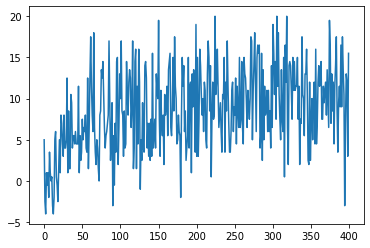

In [11]:
epochs_train=400
env = Environment(grid_size=size, max_time=T, temperature=0.3)
agent = DQN_FC(size, lr=.1, epsilon = 0.1, memory_size=200, batch_size = 32)
train(agent, env, epochs_train, prefix='fc_train')


In [16]:
test(agent,env,epochs_test,prefix='testFC')
HTML(display_videos('testFC9.pk'))

Win/lose count 19.5/17.0. Average score (2.5)
Win/lose count 14.5/16.0. Average score (0.5)
Win/lose count 18.5/19.0. Average score (0.16666666666666666)
Win/lose count 17.5/19.0. Average score (-0.25)
Win/lose count 19.5/16.0. Average score (0.5)
Win/lose count 11.5/14.0. Average score (0.0)
Win/lose count 11.0/15.0. Average score (-0.5714285714285714)
Win/lose count 22.5/17.0. Average score (0.1875)
Win/lose count 15.0/8.0. Average score (0.9444444444444444)
Win/lose count 21.0/19.0. Average score (1.05)
Final score: 1.05


***
***
__Question 8__ Implement the DQN training algorithm using a CNN (for example, 2 convolutional layers and one final fully connected layer).

In [0]:
class DQN_CNN(DQN):
    def __init__(self, *args,lr=0.01,**kwargs):
        super(DQN_CNN, self).__init__(*args,**kwargs)
        
        model= Sequential()
        model.add(Conv2D(32, kernel_size=3, activation="relu",input_shape=(5,5,self.n_state)))
        model.add(Conv2D(8, kernel_size=3, activation="relu"))
        model.add(Flatten())
        model.add(Dense(128))
        model.add(Dense(self.n_action))
        model.compile(sgd(lr=lr, decay=1e-4, momentum=0.7), "mse")
        self.model = model

Epoch 000/400 | Loss 0.0011 | Win/lose count 2.0/3.0 (-1.0)
Epoch 001/400 | Loss 0.0014 | Win/lose count 3.5/2.0 (1.5)
Epoch 002/400 | Loss 0.0145 | Win/lose count 2.5/5.0 (-2.5)
Epoch 003/400 | Loss 0.0585 | Win/lose count 5.0/4.0 (1.0)
Epoch 004/400 | Loss 0.0055 | Win/lose count 5.0/5.0 (0.0)
Epoch 005/400 | Loss 0.0032 | Win/lose count 5.0/4.0 (1.0)
Epoch 006/400 | Loss 0.0031 | Win/lose count 2.0/4.0 (-2.0)
Epoch 007/400 | Loss 0.0022 | Win/lose count 7.0/3.0 (4.0)
Epoch 008/400 | Loss 0.0028 | Win/lose count 6.5/0 (6.5)
Epoch 009/400 | Loss 0.0035 | Win/lose count 13.0/8.0 (5.0)
Epoch 010/400 | Loss 0.0013 | Win/lose count 8.0/1.0 (7.0)
Epoch 011/400 | Loss 0.0440 | Win/lose count 10.0/0 (10.0)
Epoch 012/400 | Loss 0.0028 | Win/lose count 6.0/0 (6.0)
Epoch 013/400 | Loss 0.0034 | Win/lose count 11.5/4.0 (7.5)
Epoch 014/400 | Loss 0.1042 | Win/lose count 1.5/0 (1.5)
Epoch 015/400 | Loss 0.0419 | Win/lose count 6.5/1.0 (5.5)
Epoch 016/400 | Loss 0.0022 | Win/lose count 16.0/3.0 (13

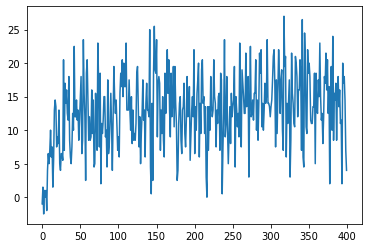

In [69]:
env = Environment(grid_size=size, max_time=T, temperature=0.3)
epochs_train=400
agent = DQN_CNN(size, lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 32)
train(agent,env,epochs_train,prefix='cnn_train')
HTML(display_videos('cnn_train390.pk'))

In [17]:
HTML(display_videos('cnn_train390.pk'))

***
***
__Question 9__ Test both algorithms and compare their performances. Which issue(s) do you observe? Observe also different behaviors by changing the temperature.

In [38]:
env = Environment(grid_size=size, max_time=T,temperature=0.3)
agent_cnn = DQN_CNN(size, lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 32)
agent_cnn.load(name_weights='cnn_trainmodel.h5',name_model='cnn_trainmodel.json')

agent_fc = DQN_FC(size, lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 32)
agent_cnn.load(name_weights='fc_trainmodel.h5',name_model='fc_trainmodel.json')
print('Test of the CNN')
test(agent_cnn,env,epochs_test,prefix='cnn_test')
print('Test of the FC')
test(agent_fc,env,epochs_test,prefix='fc_test')

Test of the CNN
Win/lose count 15.0/0. Average score (15.0)
Win/lose count 21.0/0. Average score (18.0)
Win/lose count 23.0/5.0. Average score (18.0)
Win/lose count 14.0/1.0. Average score (16.75)
Win/lose count 14.0/3.0. Average score (15.6)
Win/lose count 18.0/0. Average score (16.0)
Win/lose count 20.5/2.0. Average score (16.357142857142858)
Win/lose count 14.5/0. Average score (16.125)
Win/lose count 17.0/4.0. Average score (15.777777777777779)
Win/lose count 14.5/2.0. Average score (15.45)
Final score: 15.45
Test of the FC
Win/lose count 4.0/12.0. Average score (-8.0)
Win/lose count 3.0/3.0. Average score (-4.0)
Win/lose count 4.5/0. Average score (-1.1666666666666667)
Win/lose count 2.0/4.0. Average score (-1.375)
Win/lose count 3.5/5.0. Average score (-1.4)
Win/lose count 7.0/6.0. Average score (-1.0)
Win/lose count 2.0/2.0. Average score (-0.8571428571428571)
Win/lose count 0.5/1.0. Average score (-0.8125)
Win/lose count 6.0/4.0. Average score (-0.5)
Win/lose count 2.0/5.0. Ave

In [19]:
HTML(display_videos('cnn_test9.pk'))

In [23]:
HTML(display_videos('fc_test8.pk'))

Regardless of the configuration, the convolutional network gives better results than the fully connected network. The convolutional network is more efficient because it is invariant by translation, so if the same structure is in a different location of the 5x5 dimension state, the network will behave the same way as before. The fully connected doesn't share the weights between its neurons, that is why it is less efficient.
 As the temperature rises, the mouse is less likely to get stuck in the same area.  This is explained by the fact that more bonuses are present on the board and therefore the agent tends to explore more. At the extreme if the temperature is low, the agent will tend to stay in the same places (loops).
In any case the agent does not explore his environment enough.



***

The algorithm tends to not explore the map which can be an issue. We propose two ideas in order to encourage exploration:
1. Incorporating a decreasing $\epsilon$-greedy exploration. You can use the method ```set_epsilon```
2. Append via the environment a new state that describes if a cell has been visited or not

***
__Question 10__ Design a new ```train_explore``` function and environment class ```EnvironmentExploring``` to tackle the issue of exploration.



In [0]:
def train_explore(agent,env,epoch,prefix=''):
    
     # Number of won games
    score = 0
    loss = 0
    scores=np.zeros(epoch)
    for e in range(epoch):
        # At each epoch, we restart to a fresh game and get the initial state
        
        state = np.zeros((1,5,5,agent.n_state))
        state[0,:,:,:]= env.reset()
        # This assumes that the games will terminate
        game_over = False

        win = 0
        lose = 0

        while not game_over:
            # The agent performs an action
            #transformation of state to be ok for the input
            action = agent.act(state)

            # Apply an action to the environment, get the next state, the reward
            # and if the games end
            prev_state = state
            #reshape test to be able to feed the network
            state = np.zeros((1,5,5,agent.n_state))
            state[0,:,:,:], reward, game_over = env.act(action, train=True) 
            
            # Update the counters
            if reward > 0:
                win = win + reward
            if reward < 0:
                lose = lose -reward

            # Apply the reinforcement strategy
            loss = agent.reinforce(prev_state, state,  action, reward, game_over)
        
        # Save as a mp4
        if e % 10 == 0:
            env.draw(prefix+str(e))

        # I slowly decrease the exploration parameter
        agent.set_epsilon(agent.epsilon*0.99)
       
        # Update stats
        score = win-lose
        
        scores[e]=score
        print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {}/{} ({})"
              .format(e, epoch, loss, win, lose, win-lose))
        agent.save(name_weights=prefix+'model.h5',name_model=prefix+'model.json')
    plt.plot(scores)

    pass

class EnvironmentExploring(Environment):
    def __init__(self, grid_size=10, max_time=500, temperature=0.1):
        
        grid_size = grid_size+4
        self.grid_size = grid_size
        self.max_time = max_time
        self.temperature = temperature

        #board on which one plays
        self.board = np.zeros((grid_size,grid_size))
        self.position = np.zeros((grid_size,grid_size))
        self.malus_position=np.zeros((grid_size,grid_size))
        # coordinate of the cat
        self.x = 0
        self.y = 1

        # self time
        self.t = 0

        self.scale=16

        self.to_draw = np.zeros((max_time+2, grid_size*self.scale, grid_size*self.scale, 3))

    def draw(self,e):
        pickle.dump(self.to_draw/256, open(str(e) + '.pk', 'wb'))

    def get_frame(self,t):
        b = np.zeros((self.grid_size,self.grid_size,3))+128
        b[self.board>0,0] = 256
        b[self.board < 0, 2] = 256
        b[self.x,self.y,:]=256
        
        #I add green color for cells already visited 
        b[self.malus_position!=0,1]=256

        b[-2:,:,:]=0
        b[:,-2:,:]=0
        b[:2,:,:]=0
        b[:,:2,:]=0
        
        b =  cv2.resize(b, None, fx=self.scale, fy=self.scale, interpolation=cv2.INTER_NEAREST)

        self.to_draw[t,:,:,:]=b


    def act(self, action,train=False):
        """This function returns the new state, reward and decides if the
        game ends."""

        self.get_frame(int(self.t))

        self.position = np.zeros((self.grid_size, self.grid_size))

        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:, :] = -1
        self.position[:,-2:] = -1

        self.position[self.x, self.y] = 1
        if action == 0:
            if self.x == self.grid_size-3:
                self.x = self.x-1
            else:
                self.x = self.x + 1
        elif action == 1:
            if self.x == 2:
                self.x = self.x+1
            else:
                self.x = self.x-1
        elif action == 2:
            if self.y == self.grid_size - 3:
                self.y = self.y - 1
            else:
                self.y = self.y + 1
        elif action == 3:
            if self.y == 2:
                self.y = self.y + 1
            else:
                self.y = self.y - 1
        else:
            RuntimeError('Error: action not recognized')

        self.t = self.t + 1
        
        reward = 0
        
        if train:
            reward = -self.malus_position[self.x, self.y]
        # I add amalus position of 0.1 here in order to penalised the useless moves
        self.malus_position[self.x, self.y] = 0.1

        reward = reward + self.board[self.x, self.y]
        self.board[self.x, self.y] = 0
        
        game_over = self.t > self.max_time

        #Here I add if the cells in the 5x5 square have already been visited or not => n_states =3
        state = np.concatenate((self.malus_position.reshape(self.grid_size, self.grid_size,1),
                                self.board.reshape(self.grid_size, self.grid_size,1),
                                self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)
        state = state[self.x-2:self.x+3,self.y-2:self.y+3,:]

        return state, reward, game_over

    def reset(self):
        """This function resets the game and returns the initial state"""

        self.x = np.random.randint(3, self.grid_size-3, size=1)[0]
        self.y = np.random.randint(3, self.grid_size-3, size=1)[0]


        bonus = 0.5*np.random.binomial(1,self.temperature,size=self.grid_size**2)
        bonus = bonus.reshape(self.grid_size,self.grid_size)

        malus = -1.0*np.random.binomial(1,self.temperature,size=self.grid_size**2)
        malus = malus.reshape(self.grid_size, self.grid_size)

        self.to_draw = np.zeros((self.max_time+2, self.grid_size*self.scale, self.grid_size*self.scale, 3))


        malus[bonus>0]=0

        self.board = bonus + malus

        self.position = np.zeros((self.grid_size, self.grid_size))
        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:, :] = -1
        self.position[:,-2:] = -1
        
        self.malus_position = np.zeros((self.grid_size, self.grid_size))
        self.malus_position[0:2,:]= -1
        self.malus_position[:,0:2] = -1
        self.malus_position[-2:, :] = -1
        self.malus_position[:,-2:] = -1
       
        self.board[self.x,self.y] = 0
        self.t = 0

        state = np.concatenate((self.malus_position.reshape(self.grid_size, self.grid_size,1),
                                self.board.reshape(self.grid_size, self.grid_size,1),
                                self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)
        state = state[self.x - 2:self.x + 3, self.y - 2:self.y + 3, :]
        return state
    


Epoch 000/400 | Loss 0.0078 | Win/lose count 10.0/28.000000000000107 (-18.000000000000107)
Epoch 001/400 | Loss 0.0044 | Win/lose count 15.0/37.20000000000008 (-22.20000000000008)
Epoch 002/400 | Loss 0.0033 | Win/lose count 10.0/31.600000000000115 (-21.600000000000115)
Epoch 003/400 | Loss 0.0037 | Win/lose count 16.5/31.900000000000123 (-15.400000000000123)
Epoch 004/400 | Loss 0.0032 | Win/lose count 9.5/27.50000000000011 (-18.00000000000011)
Epoch 005/400 | Loss 0.0036 | Win/lose count 16.5/30.70000000000006 (-14.20000000000006)
Epoch 006/400 | Loss 0.0027 | Win/lose count 10.5/29.90000000000011 (-19.40000000000011)
Epoch 007/400 | Loss 0.0029 | Win/lose count 7.5/30.90000000000012 (-23.40000000000012)
Epoch 008/400 | Loss 0.0073 | Win/lose count 12.0/27.800000000000068 (-15.800000000000068)
Epoch 009/400 | Loss 0.0092 | Win/lose count 12.5/29.100000000000104 (-16.600000000000104)
Epoch 010/400 | Loss 0.0018 | Win/lose count 11.0/25.200000000000106 (-14.200000000000106)
Epoch 011/4

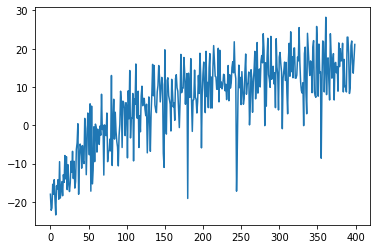

In [28]:
# Training
epochs_train=400
size=15
T=size*size

env = EnvironmentExploring(grid_size=size, max_time=T, temperature=0.3)
agent = DQN_CNN(size, lr=.1, epsilon = 0.99, memory_size=2000, batch_size = 32,n_state=3)
train_explore(agent, env, epochs_train, prefix='cnn_train_explore')


In [70]:
HTML(display_videos('cnn_train_explore390.pk'))

In [36]:
# Evaluation
test(agent,env,epochs_test,prefix='cnn_test_explore')


Win/lose count 36.5/1.0. Average score (35.5)
Win/lose count 28.0/2.0. Average score (30.75)
Win/lose count 9.0/0. Average score (23.5)
Win/lose count 28.5/0. Average score (24.75)
Win/lose count 29.5/0. Average score (25.7)
Win/lose count 37.0/4.0. Average score (26.916666666666668)
Win/lose count 17.5/0. Average score (25.571428571428573)
Win/lose count 32.5/4.0. Average score (25.9375)
Win/lose count 26.0/6.0. Average score (25.27777777777778)
Win/lose count 18.0/1.0. Average score (24.45)
Final score: 24.45


In [65]:
HTML(display_videos('cnn_test_explore5.pk'))

***
***
__BONUS question__ Use the expert DQN from the previous question to generate some winning games. Train a model that mimicks its behavior. Compare the performances.

It is possible to learn from actions from an expert agent in this way :

A new agent is trained by taking as input a state and as target the action taken by the expert player. The newbie's network assigns a probability to each action. We calculate from this output and the target (choice of the expert player) a cross-entropy loss that we try to minimize to train the novice player.

In [0]:
# Save video as gif:
from PIL import Image
def save_gif(name,save_name):
  #name="cnn_train_explore390.pk"
  video = pickle.load(open(name, 'rb'))

  #Image.fromarray(video[0])
  vect=[]
  for i,v in enumerate(video):
    vect.append(Image.fromarray(np.uint8(v)*255))

  vect[0].save(save_name+'.gif',
                save_all=True,
                append_images=vect[1:],
                duration=60,
                loop=0)
save_gif("cnn_train_explore390.pk","trainexplore390")
save_gif("cnn_test_explore9.pk","testexplore9")

save_gif("cnn_train390.pk","cnntrain390")
save_gif("cnn_test9.pk","cnntest9")

save_gif("fc_train390.pk","fctrain390")
save_gif("fc_test9.pk","fctest9")




***